In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from networkx.algorithms import bipartite

### Component info

In [2]:
comp_info = np.loadtxt('../data/recipes/comp_info.tsv', dtype=str, delimiter='\t')

In [3]:
comp_info

array([['0', 'jasmone', '488-10-8'],
       ['1', '5-methylhexanoic_acid', '628-46-6'],
       ['2', 'l-glutamine', '56-85-9'],
       ...,
       ['1104', 'guaiacol', '90-05-1'],
       ['1105', '(+/?)-methyl_5-acetoxyhexanoate', '35234-22-1'],
       ['1106', 'ethyl_sorbate', '2396-84-1']], dtype='<U93')

In [4]:
id_comp_dict = dict()
for line in comp_info:
    id_comp_dict[int(line[0])] = line[1]
comp_id_dict = {v:k for k, v in id_comp_dict.items()}

### Ingredient info

In [5]:
ingr_info = np.loadtxt('../data/recipes/ingr_info.tsv', dtype=str, delimiter='\t')

In [6]:
ingr_info

array([['0', 'magnolia_tripetala', 'flower'],
       ['1', 'calyptranthes_parriculata', 'plant'],
       ['2', 'chamaecyparis_pisifera_oil', 'plant derivative'],
       ...,
       ['1527', 'green_tea', 'plant derivative'],
       ['1528', 'artemisia_porrecta_oil', 'plant derivative'],
       ['1529', 'munster_cheese', 'dairy']], dtype='<U35')

In [7]:
id_ingr_dict = dict()
for line in ingr_info:
    id_ingr_dict[int(line[0])] = line[1]
ingr_id_dict = {v:k for k, v in id_ingr_dict.items()}

### Recipes and regions

In [8]:
recipes_dict = dict()
regions_dict = dict()

In [9]:
with open('../data/recipes/menu_recipes.txt') as f:
    for i, line in enumerate(f):
        alist = line.rstrip('\n').split()
        region = alist[0]
        ingr = alist[1:]
        regions_dict[i] = region
        recipes_dict[i] = ingr

In [10]:
id_region_dict = dict()
region_id_dict = dict()
for i, region in enumerate(set(regions_dict.values())):
    id_region_dict[i] = region
    region_id_dict[region] = i

### Region/recipe biadjacency matrix

In [11]:
bmat_region_recipe = np.zeros((len(id_region_dict), len(recipes_dict)))
for recipe, region in regions_dict.items():
    j = recipe
    i = region_id_dict[region]
    bmat_region_recipe[i, j] = 1

In [12]:
bmat_region_recipe.shape

(8, 2458)

### Recipe/ingredient biadjacency matrix

In [13]:
bmat_recipe_ingr = np.zeros((len(recipes_dict), len(id_ingr_dict)))
for recipe, ingreds in recipes_dict.items():
    i = recipe
    jlist = [ingr_id_dict[x] for x in ingreds]
    bmat_recipe_ingr[i, jlist] = 1

In [14]:
print([id_ingr_dict[x] for x in np.argwhere(bmat_recipe_ingr[0]).flatten()])
print(recipes_dict[0])

['sesame_oil', 'garlic', 'lettuce', 'beef', 'sake', 'beef_broth', 'scallion', 'oyster', 'vegetable_oil', 'soy_sauce', 'starch', 'onion']
['onion', 'beef', 'starch', 'sake', 'soy_sauce', 'scallion', 'lettuce', 'garlic', 'vegetable_oil', 'beef_broth', 'oyster', 'sesame_oil']


In [15]:
bmat_recipe_ingr.shape

(2458, 1530)

### Ingredient/compound biadjacency matrix

In [16]:
ingr_comp = np.loadtxt('../data/recipes/ingr_comp.tsv', dtype=int, delimiter='\t')

In [17]:
ingr_comp

array([[1392,  906],
       [1259,  861],
       [1079,  673],
       ...,
       [ 689,  650],
       [ 689,  297],
       [1080,   13]])

In [18]:
bmat_ingr_comp = np.zeros((len(id_ingr_dict), len(id_comp_dict)))
for item in ingr_comp:
    i, j = item
    bmat_ingr_comp[i, j] = 1

In [19]:
print(bmat_ingr_comp[1392, 906])
print(bmat_ingr_comp[1392, 907])

1.0
0.0


In [20]:
bmat_ingr_comp.shape

(1530, 1107)

### Setup for link prediction

In [21]:
import os
import sys
linkpred_path = os.path.abspath(os.path.join('../linkpred/'))
if linkpred_path not in sys.path:
    sys.path.append(linkpred_path)

import b_lcp, b_mi, b_probas, b_si, b_util, b_val

In [34]:
fraction = 0.1
loops = 1
verbose=True
plot=True

In [36]:
# Precompute links to delete for all datasets
links_to_del_region_recipe = b_val.get_links_to_del(bmat_region_recipe, fraction=fraction, loops=loops)
links_to_del_recipe_ingr = b_val.get_links_to_del(bmat_recipe_ingr, fraction=fraction, loops=loops)
links_to_del_ingr_comp = b_val.get_links_to_del(bmat_ingr_comp, fraction=fraction, loops=loops)

### Recipe-Ingredient

Trial 1 of 1
Computing bipartite LCP
100.00 %, 17.10 minutes


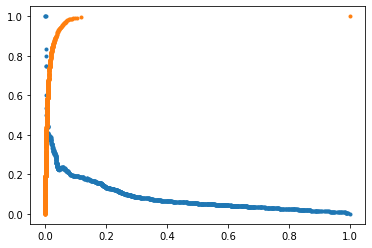

[0.08466677 0.98523001]
[0. 0.]


In [37]:
# CN
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing bipartite LCP
100.00 %, 16.55 minutes


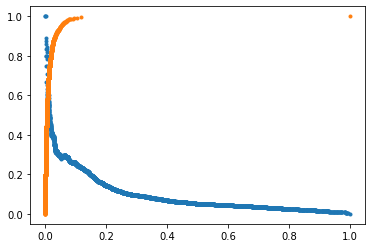

[0.09614285 0.98558758]
[0. 0.]


In [38]:
# LCL
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('lcl',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing bipartite LCP
100.00 %, 13.35 minutes


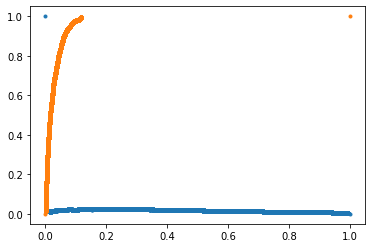

[0.0238256  0.97212931]
[0. 0.]


In [39]:
# JC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('jc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing bipartite LCP
100.00 %, 13.09 minutes


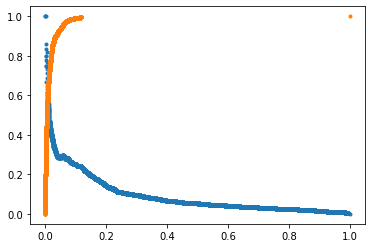

[0.09420374 0.98503235]
[0. 0.]


In [40]:
# CJC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cjc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing bipartite LCP
100.00 %, 12.79 minutes


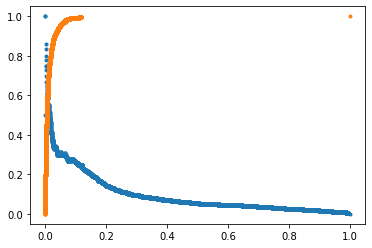

[0.09703129 0.98620472]
[0. 0.]


In [41]:
# CRA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing bipartite LCP
100.00 %, 13.18 minutes


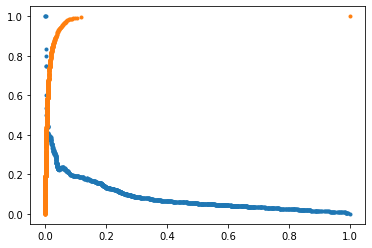

[0.08466677 0.98523001]
[0. 0.]


In [42]:
# CAR
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing bipartite LCP
100.00 %, 13.22 minutes


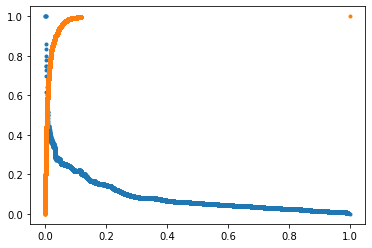

[0.08929523 0.98548976]
[0. 0.]


In [43]:
# RA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('ra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing bipartite LCP
100.00 %, 13.21 minutes


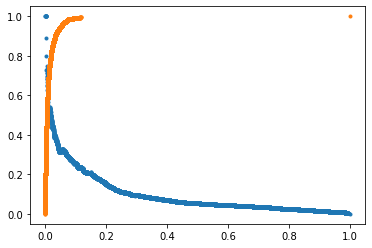

[0.09958673 0.98555698]
[0. 0.]


In [44]:
# CPA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *('cpa',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [45]:
# MI links
r = b_val.cross_val(b_si.si_scores, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *(b_probas.proba_comb_links_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing mutual information
6.00 %, 508.69 minutes

KeyboardInterrupt: 

In [ ]:
# MI degree
r = b_val.cross_val(b_si.si_scores, bmat_recipe_ingr, links_to_del_recipe_ingr, 
                    *(b_probas.proba_comb_deg_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

### Ingredient-Compound

Trial 1 of 1
Computing bipartite LCP


/Users/paul.herringer/multipartite-weighted-link-prediction/recipes/b_lcp.py:99: RuntimeWarning: overflow encountered in double_scalars
  unfav = comb(x.shape[1]-1, deg_r) * comb(x.shape[0]-1, deg_c)
/Users/paul.herringer/multipartite-weighted-link-prediction/recipes/b_lcp.py:100: RuntimeWarning: divide by zero encountered in log2
  cpi[i] = np.log2(fav / (fav + unfav))
/Users/paul.herringer/multipartite-weighted-link-prediction/recipes/b_lcp.py:98: RuntimeWarning: overflow encountered in double_scalars
  fav = comb(x.shape[1]-1, deg_r-1) * comb(x.shape[0]-1, deg_c-1)
/Users/paul.herringer/multipartite-weighted-link-prediction/recipes/b_lcp.py:100: RuntimeWarning: invalid value encountered in double_scalars
  cpi[i] = np.log2(fav / (fav + unfav))


100.00 %, 15.14 minutes


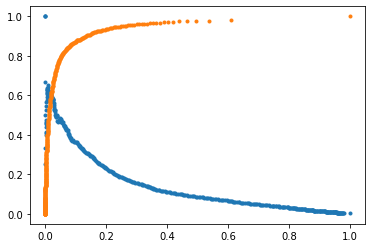

[0.13953159 0.94558656]
[0. 0.]


In [46]:
# CN
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing bipartite LCP
100.00 %, 16.70 minutes


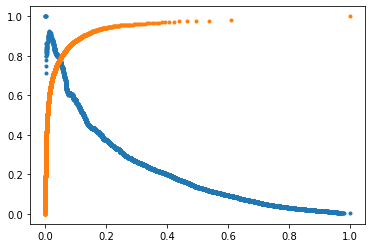

[0.2176406  0.94901535]
[0. 0.]


In [47]:
# LCL
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('lcl',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [48]:
# JC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('jc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing bipartite LCP
14.00 %, 2.18 minutes

KeyboardInterrupt: 

In [ ]:
# CJC
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cjc',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CRA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CAR
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cn',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# RA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('ra',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [ ]:
# CPA
r = b_val.cross_val(b_lcp.bipartite_lcp_single, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *('cpa',), mode='lcp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

In [45]:
# MI links
r = b_val.cross_val(b_si.si_scores, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *(b_probas.proba_comb_links_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))

Trial 1 of 1
Computing mutual information
6.00 %, 508.69 minutes

KeyboardInterrupt: 

In [ ]:
# MI degree
r = b_val.cross_val(b_si.si_scores, bmat_ingr_comp, links_to_del_ingr_comp, 
                    *(b_probas.proba_comb_deg_all, b_mi.mi_lcl_cc), 
                   mode='si_bp', loops=loops, verbose=verbose, plot=plot)
print(np.mean(r, axis=0))
print(np.std(r, axis=0))